Converged at trial 108


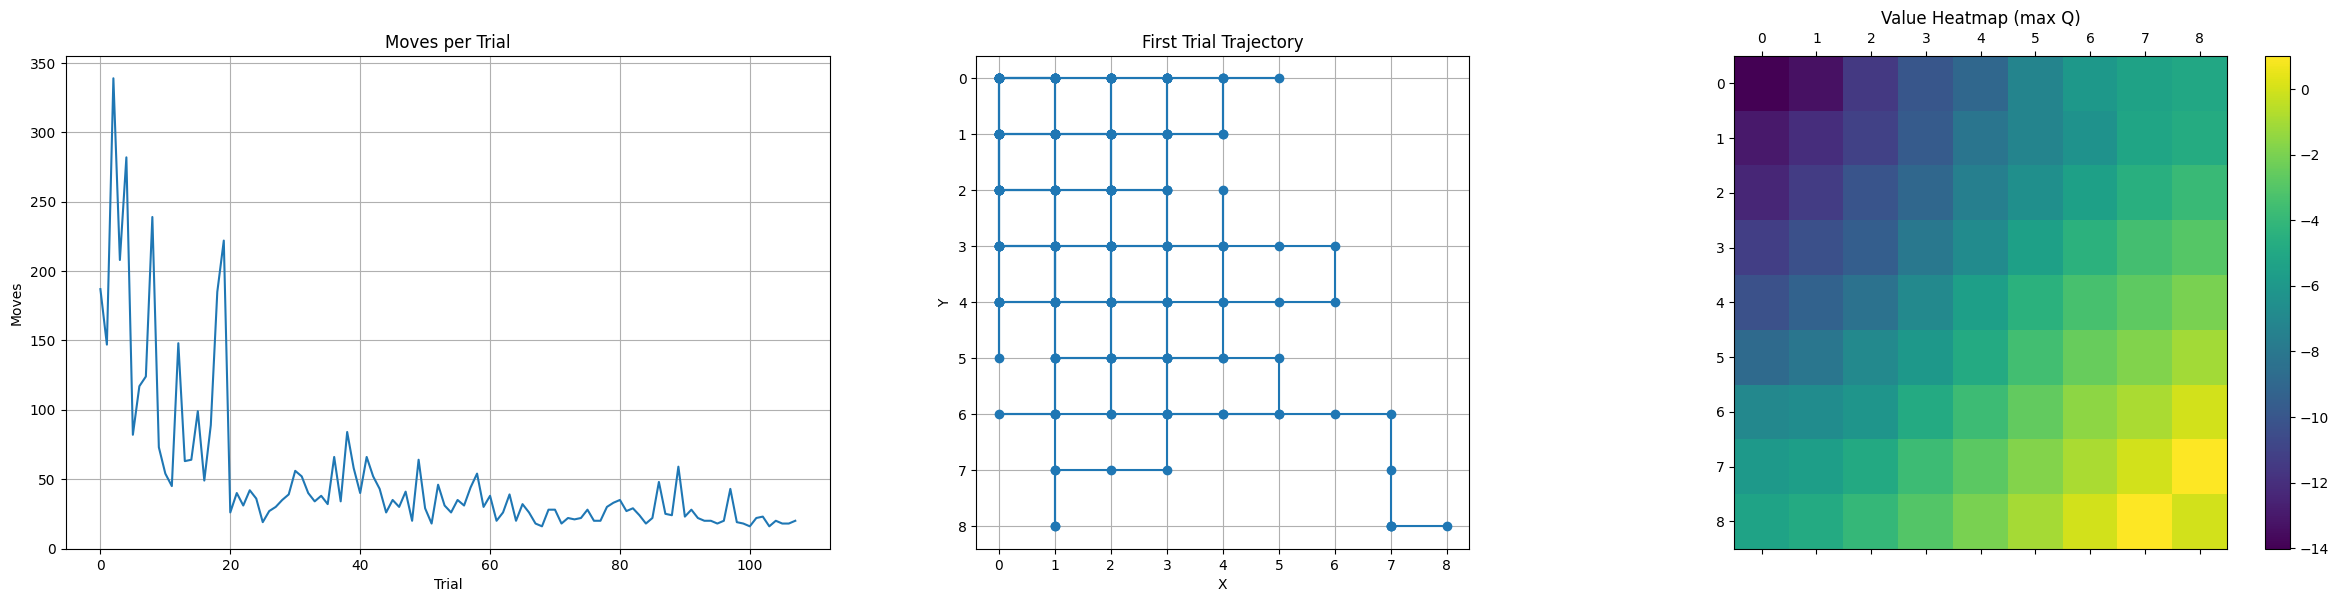

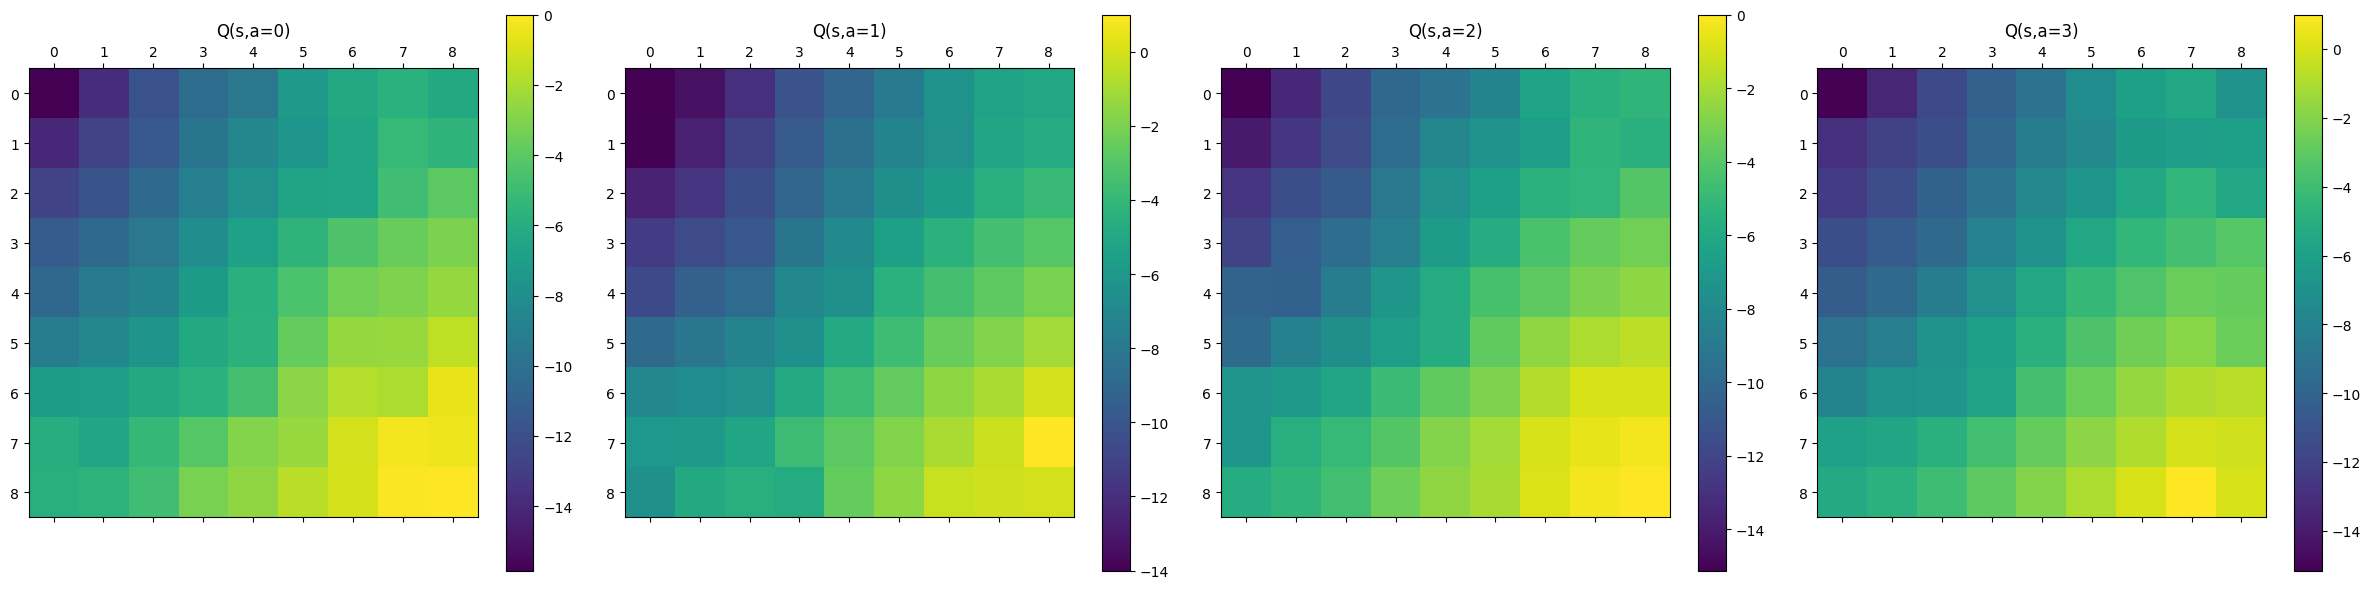

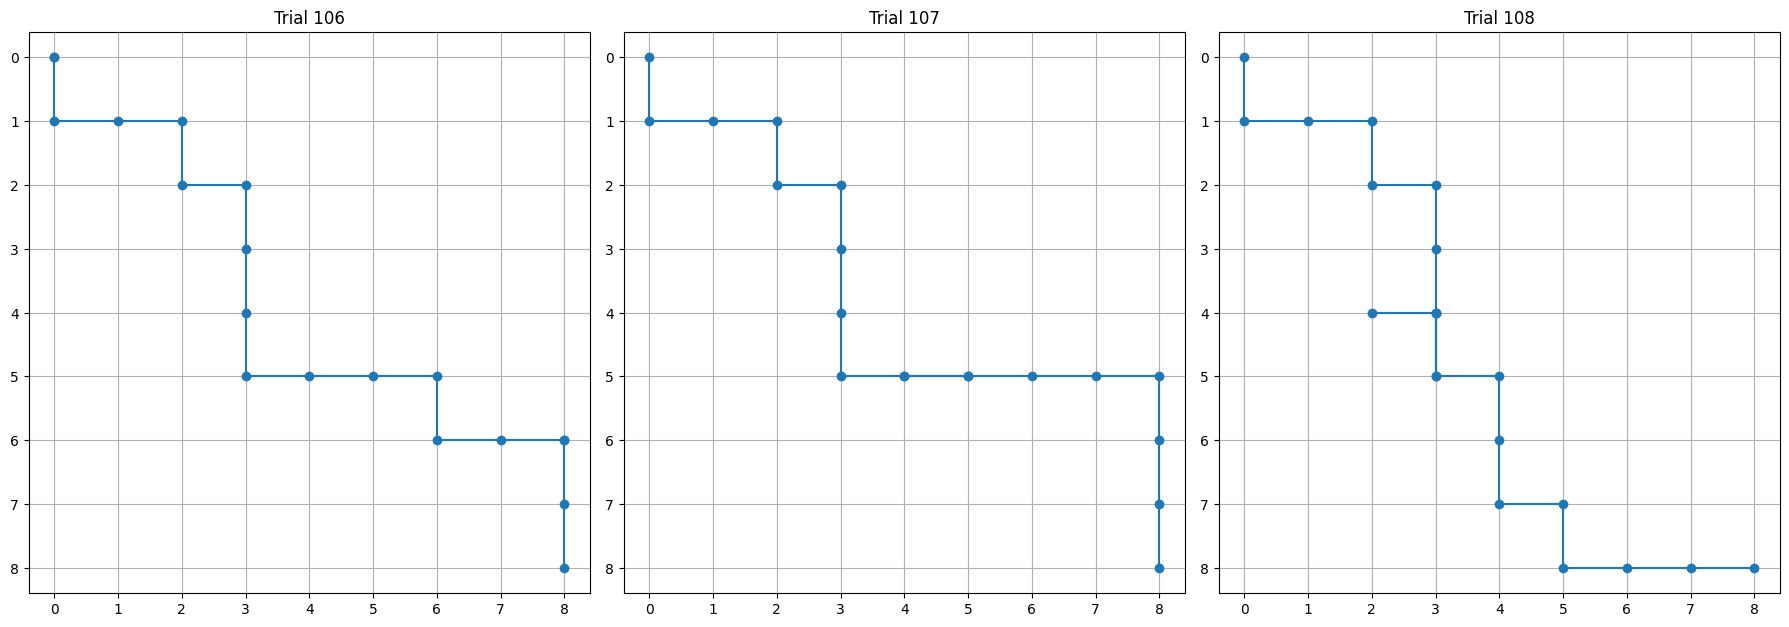

In [1]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import random

# ─── 1) Define a simple GridWorld Gym Env ─────────────────────────────────────
class GridWorldEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, grid_size=9):
        super().__init__()
        self.grid_size      = grid_size
        self.observation_space = spaces.Discrete(grid_size * grid_size)
        self.action_space      = spaces.Discrete(4)   # 0:left,1:right,2:up,3:down
        self.start_state    = 0
        self.goal_state     = grid_size*grid_size - 1
        self.state          = self.start_state

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        r = self.state // self.grid_size
        c = self.state %  self.grid_size
        if   action == 0: c = max(0, c-1)       # left
        elif action == 1: c = min(self.grid_size-1, c+1)  # right
        elif action == 2: r = max(0, r-1)       # up
        elif action == 3: r = min(self.grid_size-1, r+1)  # down

        next_state = r*self.grid_size + c
        reward     = 1 if next_state==self.goal_state else -1
        done       = (next_state == self.goal_state)
        self.state = next_state
        return next_state, reward, done, {}

    def render(self, mode='human'):
        grid = np.zeros((self.grid_size, self.grid_size), dtype=str)
        grid[:] = '.'
        rr, cc = divmod(self.state, self.grid_size)
        gr, gc = divmod(self.goal_state, self.grid_size)
        grid[rr,cc] = 'A'
        grid[gr,gc] = 'G'
        print("\n".join(" ".join(row) for row in grid))
        print()

# ─── 2) Hyperparameters & Helpers ─────────────────────────────────────────────
grid_size       = 9
alpha           = 0.1
gamma           = 0.99
epsilon         = 0.1
tau             = 1.0
lambda_         = 0.9
max_trials      = 1000
softmax_policy  = False
criterion_moves = 20
min_successes   = 5

def state_to_pos(s): return divmod(s, grid_size)

def select_eps(s, Q):
    if random.random() < epsilon:
        return random.randrange(4)
    return int(np.argmax(Q[s]))

def select_soft(s, Q):
    q = Q[s]
    m = q.max()
    e = np.exp((q-m)/tau)
    p = e / e.sum()
    return int(np.random.choice(4, p=p))

# ─── 3) Initialize Env, Q, Traces ─────────────────────────────────────────────
env = GridWorldEnv(grid_size=grid_size)
Q   = np.random.uniform(0, 0.01, (env.observation_space.n, env.action_space.n))
E   = np.zeros_like(Q)

moves_per_trial     = []
consecutive_success = 0
first_traj          = None
last_three_info     = []
convergence_trial   = None

# ─── 4) Training Loop with Watkins’s Q(λ) ────────────────────────────────────
for trial in range(1, max_trials+1):
    state = env.reset()
    E.fill(0)
    moves = 0
    traj  = [state]

    # pick first action
    action = select_soft(state, Q) if softmax_policy else select_eps(state, Q)

    while True:
        next_state, reward, done, _ = env.step(action)
        moves += 1
        traj.append(next_state)

        # compute targets
        greedy_next = int(np.argmax(Q[next_state]))
        if softmax_policy:
            next_action = select_soft(next_state, Q)
        else:
            next_action = select_eps(next_state, Q)

        # TD error for Q-learning
        delta = reward + gamma * Q[next_state, greedy_next] - Q[state, action]

        # accumulate and update
        E[state, action] += 1
        Q += alpha * delta * E
        E *= gamma * lambda_

        # Watkins’s trick
        if next_action != greedy_next:
            E.fill(0)

        state, action = next_state, next_action

        if done:
            break

    moves_per_trial.append(moves)
    if trial == 1:
        first_traj = traj.copy()

    last_three_info.append((trial, traj.copy()))
    if len(last_three_info) > 3:
        last_three_info.pop(0)

    # convergence check
    if moves <= criterion_moves:
        consecutive_success += 1
        if consecutive_success >= min_successes:
            convergence_trial = trial
            print(f"Converged at trial {trial}")
            break
    else:
        consecutive_success = 0

if convergence_trial is None:
    print(f"Did not converge in {max_trials} trials")

# ─── 5) Plots ─────────────────────────────────────────────────────────────────
# Plot learning curve / first trajectory / value heatmap
fig, ax = plt.subplots(1, 3, figsize=(24,6))
ax[0].plot(moves_per_trial); ax[0].set(title='Moves per Trial', xlabel='Trial', ylabel='Moves'); ax[0].grid()

# First-trial trajectory
xs, ys = zip(*(state_to_pos(s) for s in first_traj))
ax[1].plot(xs, ys, '-o'); ax[1].invert_yaxis(); ax[1].set_aspect('equal')
ax[1].set(title='First Trial Trajectory', xlabel='X', ylabel='Y'); ax[1].grid()

# Value heatmap V(s) = max_a Q(s,a)
V = np.max(Q, axis=1).reshape((grid_size, grid_size)).T
cax = ax[2].matshow(V, cmap='viridis'); fig.colorbar(cax, ax=ax[2])
ax[2].set(title='Value Heatmap (max Q)')

plt.tight_layout()
plt.show()

# Plot Q-value heatmaps
fig2, ax2 = plt.subplots(1, env.action_space.n, figsize=(24,6))
for i in range(env.action_space.n):
    H = Q[:,i].reshape((grid_size, grid_size)).T
    cax = ax2[i].matshow(H, cmap='viridis')
    ax2[i].set_title(f"Q(s,a={i})")
    fig2.colorbar(cax, ax=ax2[i])
plt.tight_layout(); plt.show()

# Plot last three trajectories
fig3, ax3 = plt.subplots(1, 3, figsize=(18,6))
for idx,(t_num, t_traj) in enumerate(last_three_info):
    xs, ys = zip(*(state_to_pos(s) for s in t_traj))
    ax3[idx].plot(xs, ys, '-o'); ax3[idx].invert_yaxis(); ax3[idx].set_aspect('equal')
    ax3[idx].set(title=f'Trial {t_num}'); ax3[idx].grid()
plt.tight_layout(); plt.show()